In [ ]:
import os
import sys

import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

import h5py
import numpy as np

tf.test.gpu_device_name()

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# add src to path
sys.path.insert(0,'/content/gdrive/MyDrive/fake-faces-detector/src')
from utils.color_space_operations import all_colorspaces_from_rgb, rgb_to_ycbcr, rgb_to_hsv

# Functions

In [ ]:
def load_dataset_h5(path, dataset_name):
    with h5py.File(path, "r") as hf:
        print(hf.keys())
        X = hf[dataset_name][:]
        hf.close()
    return X

In [ ]:
def getHCbCr(np_X, type="int"):
    for i in range(np_X.shape[0]):
        np_all = all_colorspaces_from_rgb(np_X[i], type=type)
        np_X[i,:,:,0] = np_all[:,:,3]    # H into R place
        np_X[i,:,:,1] = np_all[:,:,7]    # H into R place
        np_X[i,:,:,2] = np_all[:,:,8]    # H into R place
        del np_all
    return np_X

In [ ]:
def getHSV(np_X, type="int"):
    for i in range(np_X.shape[0]):
        np_X[i] = rgb_to_hsv(np_X[i], type=type)
    return np_X

In [ ]:
def getYCbCr(np_X, type="int"):
    for i in range(np_X.shape[0]):
        np_X[i] = rgb_to_ycbcr(np_X[i], type=type)
    return np_X

In [ ]:
def get_xception():
    base_model = Xception(include_top=False, weights=None, classes=2)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def get_densenet():
    base_model = DenseNet201(include_top=False, weights=None, classes=2)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Loading datasets

In [ ]:
path = '/content/gdrive/MyDrive/masterDB/train.h5'
path_val = '/content/gdrive/MyDrive/masterDB/train.h5'
available_models = ['Xception', 'Dense']
available_inputs = ['RGB', 'HCbCr', 'HSV', 'YCbCr']

In [ ]:
model_name = 'Xception'
input = "HCbCr"

number_of_train_imgs = 6500
number_of_val_imgs = 1200

In [ ]:
X_train = load_dataset_h5(path, 'X_train')[:number_of_train_imgs]
y_train = load_dataset_h5(path, 'y_train')[:number_of_train_imgs].reshape((-1,1))

<KeysViewHDF5 ['X_train', 'y_train']>
<KeysViewHDF5 ['X_train', 'y_train']>


In [ ]:
X_val = load_dataset_h5(path_val, 'X_train')[:number_of_val_imgs]
y_val = load_dataset_h5(path_val, 'y_train')[:number_of_val_imgs].reshape((-1,1))

<KeysViewHDF5 ['X_train', 'y_train']>
<KeysViewHDF5 ['X_train', 'y_train']>


In [ ]:
if input == "HCbCr":
    X_train = getHCbCr(X_train)
    X_val = getHCbCr(X_val)
elif input == "RGB":
    pass
elif input == "HSV":
    X_train = getHSV(X_train)
    X_val = getHSV(X_val)
elif input == "YCbCr":
    X_train = getYCbCr(X_train)
    X_val = getYCbCr(X_val)
elif input not in available_inputs:
    raise ValueError("Bad input specified")
else: 
    raise NotImplementedError("Specified input not implemented")

# Create model

In [ ]:
from tensorflow.keras.applications import Xception, DenseNet201
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import xception, densenet

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
if model_name == 'Dense':
    X_train= densenet.preprocess_input(X_train)
    X_val = densenet.preprocess_input(X_val)
    model = get_densenet()
elif model_name == 'Xception':
    X_train= xception.preprocess_input(X_train)
    X_val = xception.preprocess_input(X_val)
    model = get_xception()
elif model_name not in available_models:
    raise ValueError("Bad model specified")
else: 
    raise NotImplementedError("Specified model not implemented")

In [ ]:
results = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
204/204 [==============================] - 242s 1s/step - loss: 0.5303 - accuracy: 0.7397 - val_loss: 0.6937 - val_accuracy: 0.4975
Epoch 2/10
204/204 [==============================] - 215s 1s/step - loss: 0.2785 - accuracy: 0.8865 - val_loss: 0.6844 - val_accuracy: 0.4975
Epoch 3/10
204/204 [==============================] - 215s 1s/step - loss: 0.1697 - accuracy: 0.9366 - val_loss: 0.1730 - val_accuracy: 0.9342
Epoch 4/10
204/204 [==============================] - 215s 1s/step - loss: 0.1599 - accuracy: 0.9386 - val_loss: 1.4188 - val_accuracy: 0.7117
Epoch 5/10
204/204 [==============================] - 215s 1s/step - loss: 0.0791 - accuracy: 0.9705 - val_loss: 0.1645 - val_accuracy: 0.9367
Epoch 6/10
204/204 [==============================] - 215s 1s/step - loss: 0.0580 - accuracy: 0.9792 - val_loss: 0.1751 - val_accuracy: 0.9425
Epoch 7/10
204/204 [==============================] - 215s 1s/step - loss: 0.0459 - accuracy: 0.9828 - val_loss: 0.0170 - val_accuracy: 0.9933

## Evaluation

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
saving_dir = f"/content/gdrive/MyDrive/fake-faces-detector/exp/models/{model_name}_{input}"
if os.path.exists(saving_dir) == False:
    os.makedirs(saving_dir)

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.to_csv(os.path.join(saving_dir, 'losses.csv'))

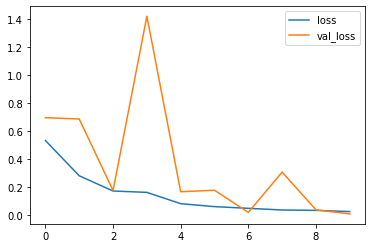

In [ ]:
losses[['loss', 'val_loss']].plot()
plt.savefig(os.path.join(saving_dir, 'loss.png'))

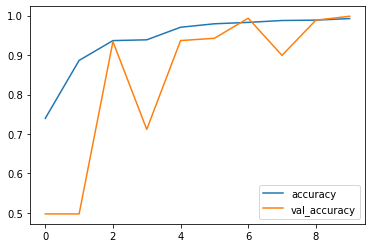

In [ ]:
losses[['accuracy', 'val_accuracy']].plot()
plt.savefig(os.path.join(saving_dir, 'acc.png'))

In [ ]:
model.save(os.path.join(saving_dir, 'model.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
